In [17]:
import pandas as pd
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pickle
from datetime import datetime, timedelta

(TEST) mencari tahu f1 score apakah sebuah mesin akan mengalami kerusakan atau tidak menggunakan model machine learning XGBoost Classifier.

In [18]:
df = pd.read_csv('dataset.csv')

X = df[['jam_operasi', 'jumlah_produk', 'usia_mesin_bulan', 'hari_sejak_servis']]
y = df['kerusakan']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.80      0.52      0.63        23
           1       0.35      0.67      0.46         9

    accuracy                           0.56        32
   macro avg       0.58      0.59      0.55        32
weighted avg       0.67      0.56      0.58        32



In [19]:
df['tanggal'] = pd.to_datetime(df['tanggal'])
df = df.sort_values(by=['id_mesin', 'tanggal'])

df['days_to_failure'] = np.nan
for mesin_id in df['id_mesin'].unique():
    mesin_data = df[df['id_mesin'] == mesin_id]
    failure_dates = mesin_data[mesin_data['kerusakan'] == 1]['tanggal'].values
    for i, row in mesin_data.iterrows():
        future_failures = failure_dates[failure_dates > np.datetime64(row['tanggal'])]
        if len(future_failures) > 0:
            days = (future_failures[0] - row['tanggal']).days  
            df.at[i, 'days_to_failure'] = days

df_rul = df.dropna(subset=['days_to_failure'])

X = df_rul[['jam_operasi', 'jumlah_produk', 'usia_mesin_bulan', 'hari_sejak_servis']]
y = df_rul['days_to_failure']
df_rul.head(100)


,tanggal,id_mesin,jenis_mesin,jam_operasi,jumlah_produk,usia_mesin_bulan,terakhir_servis,hari_sejak_servis,kerusakan,days_to_failure
0,2025-06-25,MJ-001,Jahit,4.6,81,18,2025-03-06,111,1,1.0
1,2025-06-26,MJ-001,Jahit,5.5,106,18,2025-03-06,112,1,1.0
2,2025-06-27,MJ-001,Jahit,7.1,121,18,2025-03-06,113,1,4.0
3,2025-06-28,MJ-001,Jahit,6.1,126,18,2025-03-06,114,0,3.0
4,2025-06-29,MJ-001,Jahit,4.2,88,18,2025-03-06,115,0,2.0
...,...,...,...,...,...,...,...,...,...,...
104,2025-06-29,MO-001,Obras,4.4,79,29,2025-02-26,123,1,5.0
105,2025-06-30,MO-001,Obras,7.9,132,29,2025-02-26,124,0,4.0
106,2025-07-01,MO-001,Obras,4.1,92,29,2025-02-26,125,0,3.0
107,2025-07-02,MO-001,Obras,7.2,133,29,2025-02-26,126,0,2.0


(TEST): visualisasi days_to_failure

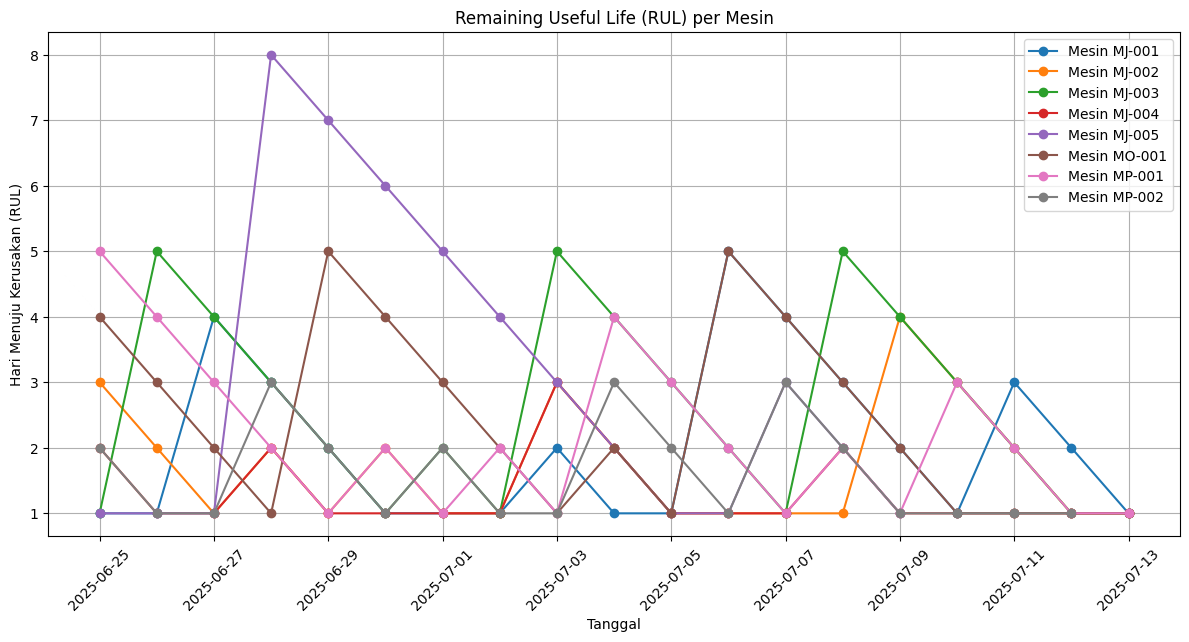

In [20]:


plt.figure(figsize=(12, 6))

for mesin_id in df_rul['id_mesin'].unique():
    subset = df_rul[df_rul['id_mesin'] == mesin_id]
    plt.plot(subset['tanggal'], subset['days_to_failure'],
             label=f'Mesin {mesin_id}', marker='o')

plt.title("Remaining Useful Life (RUL) per Mesin")
plt.xlabel("Tanggal")
plt.ylabel("Hari Menuju Kerusakan (RUL)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [21]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
df = df.reset_index(drop=True)
y_pred = model.predict(X_test)
model = XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
df_pred = X_test.copy()
df_pred['rul_asli'] = y_test.values
df_pred['tanggal'] = df['tanggal'].iloc[X_test.index].values
df_pred['rul_prediksi'] = y_pred
df_pred['id_mesin'] = df['id_mesin'].iloc[X_test.index].values
df_pred['tanggal_prediksi_kerusakan'] = df_pred['tanggal'] + pd.to_timedelta(df_pred['rul_prediksi'], unit='D')
df_pred['jenis_mesin'] = df['jenis_mesin'].iloc[X_test.index].values
df_pred['jumlah_produk'] =df['jumlah_produk'].iloc[X_test.index].values
df_pred['kerusakan']=  df['kerusakan'].iloc[X_test.index].values
df_pred['jam_operasi'] =df['jam_operasi'].iloc[X_test.index].values
mae_total = mean_absolute_error(y_test, y_pred)
print(f"MAE : {mae_total:.2f} hari")

mae_per_mesin = df_pred.groupby('id_mesin').apply(lambda d: mean_absolute_error(d['rul_asli'], d['rul_prediksi'])).reset_index()
mae_per_mesin.columns = ['id_mesin', 'mae_per_mesin']

df_pred = df_pred.merge(mae_per_mesin, on='id_mesin', how='left')






MAE : 1.30 hari


/var/folders/cl/v7j_h2x93yxg5zp804jkth9h0000gn/T/ipykernel_71327/3813182183.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_per_mesin = df_pred.groupby('id_mesin').apply(lambda d: mean_absolute_error(d['rul_asli'], d['rul_prediksi'])).reset_index()


In [22]:
df_pred.head(1000)


,jam_operasi,jumlah_produk,usia_mesin_bulan,hari_sejak_servis,rul_asli,tanggal,rul_prediksi,id_mesin,tanggal_prediksi_kerusakan,jenis_mesin,kerusakan,mae_per_mesin
0,6.2,275,19,84,3.0,2025-07-10,0.859620,MP-001,2025-07-10 20:37:51.170997622,Pemotong,1,1.787910
1,5.3,91,18,105,5.0,2025-07-08,2.073914,MJ-003,2025-07-10 01:46:26.132812504,Jahit,1,1.778954
2,7.5,332,22,79,3.0,2025-07-04,1.530578,MP-002,2025-07-05 12:44:01.909790036,Pemotong,1,0.708134
3,5.3,83,29,106,3.0,2025-06-25,1.097497,MJ-002,2025-06-26 02:20:23.780822752,Jahit,1,1.333152
4,6.7,142,29,132,3.0,2025-07-08,2.323765,MO-001,2025-07-10 07:46:13.258209227,Obras,0,1.030109
5,6.7,120,18,123,4.0,2025-07-07,2.477557,MJ-001,2025-07-09 11:27:40.919952389,Jahit,0,1.388841
6,7.4,121,16,83,1.0,2025-06-25,2.744592,MJ-005,2025-06-27 17:52:12.744598385,Jahit,0,2.453571
7,5.6,127,29,118,1.0,2025-07-07,3.781477,MJ-002,2025-07-10 18:45:19.610595702,Jahit,1,1.333152
8,6.5,110,16,88,6.0,2025-06-30,2.099098,MJ-005,2025-07-02 02:22:42.043762202,Jahit,0,2.453571
9,5.8,93,18,120,1.0,2025-07-04,1.033611,MJ-001,2025-07-05 00:48:23.954315186,Jahit,0,1.388841


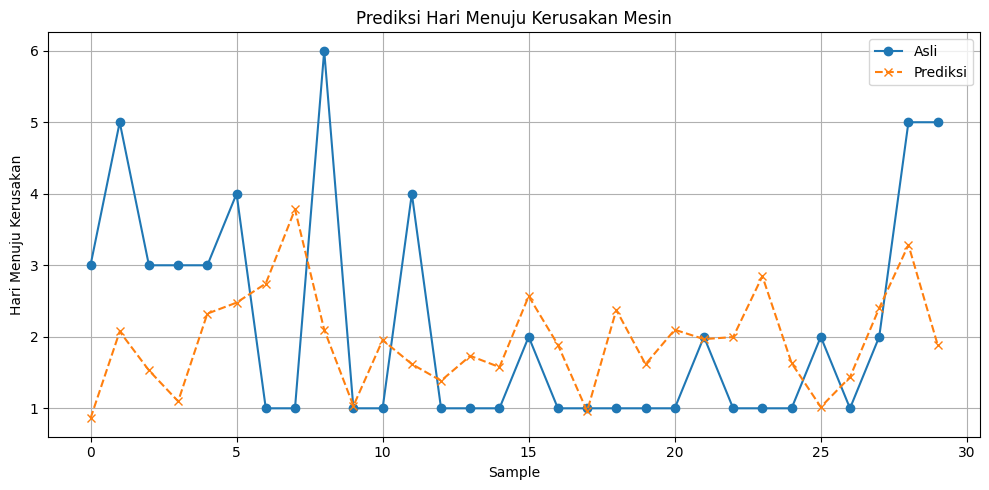

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Asli', marker='o')
plt.plot(y_pred, label='Prediksi', linestyle='--', marker='x')
plt.title('Prediksi Hari Menuju Kerusakan Mesin')
plt.xlabel('Sample')
plt.ylabel('Hari Menuju Kerusakan')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
jeda_hari = 5
df_pred['tanggal_servis_direkomendasikan'] = df_pred['tanggal_prediksi_kerusakan'] - abs(pd.to_timedelta(jeda_hari, unit='D'))
def kategori_servis(rul):
    if rul <= 3:
        return 'red'
    elif rul <= 7:
        return 'yellow'
    else:
        return 'green'
df_pred['rekomendasi_servis'] = df_pred['rul_prediksi'].apply(kategori_servis)
df_rekom = df_pred.sort_values(by='tanggal', ascending=False).groupby('id_mesin')
df_rekom_final = df_rekom[['id_mesin', 'rul_prediksi','tanggal', 'tanggal_prediksi_kerusakan', 'tanggal_servis_direkomendasikan', 'rekomendasi_servis']]
df_rekom_final.head(100)


,id_mesin,rul_prediksi,tanggal,tanggal_prediksi_kerusakan,tanggal_servis_direkomendasikan,rekomendasi_servis
16,MJ-001,1.888233,2025-07-13,2025-07-14 21:19:03.316268922,2025-07-09 21:19:03.316268922,red
24,MJ-003,1.631822,2025-07-12,2025-07-13 15:09:49.378738406,2025-07-08 15:09:49.378738406,red
22,MJ-002,1.996211,2025-07-12,2025-07-13 23:54:32.655487060,2025-07-08 23:54:32.655487060,red
0,MP-001,0.859620,2025-07-10,2025-07-10 20:37:51.170997622,2025-07-05 20:37:51.170997622,red
21,MO-001,1.967530,2025-07-09,2025-07-10 23:13:14.582748408,2025-07-05 23:13:14.582748408,red
18,MP-001,2.376049,2025-07-09,2025-07-11 09:01:30.616607668,2025-07-06 09:01:30.616607668,red
12,MP-002,1.385752,2025-07-09,2025-07-10 09:15:28.948974612,2025-07-05 09:15:28.948974612,red
1,MJ-003,2.073914,2025-07-08,2025-07-10 01:46:26.132812504,2025-07-05 01:46:26.132812504,red
4,MO-001,2.323765,2025-07-08,2025-07-10 07:46:13.258209227,2025-07-05 07:46:13.258209227,red
5,MJ-001,2.477557,2025-07-07,2025-07-09 11:27:40.919952389,2025-07-04 11:27:40.919952389,red


melihat penurunan efisiensi produksi jika terjadi kerusakan atau enggak ()

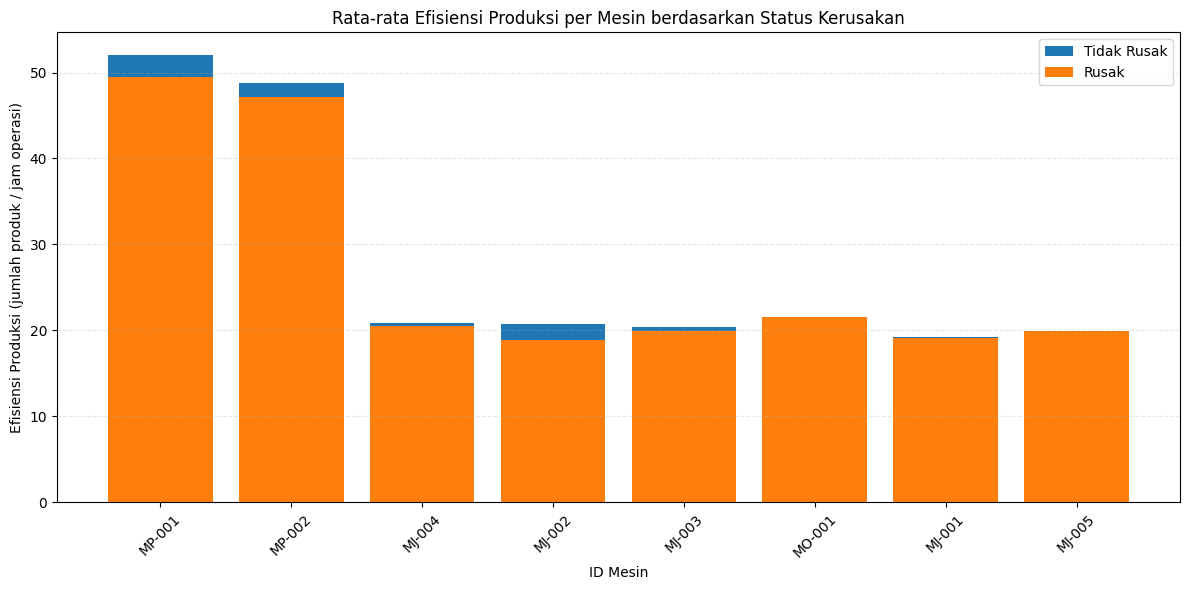

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

df['efisiensi_produksi'] = df['jumlah_produk'] / df['jam_operasi']
df['status'] = df['kerusakan'].map({0: 'Tidak Rusak', 1: 'Rusak'})
efisiensi_per_mesin = (
    df
    .groupby(['id_mesin', 'status'])['efisiensi_produksi']
    .mean()
    .reset_index()
    .sort_values(by='efisiensi_produksi', ascending=False)
)
plt.figure(figsize=(12, 6))
for status in efisiensi_per_mesin['status'].unique():
    subset = efisiensi_per_mesin[efisiensi_per_mesin['status'] == status]
    plt.bar(subset['id_mesin'], subset['efisiensi_produksi'], label=status)

plt.title('Rata-rata Efisiensi Produksi per Mesin berdasarkan Status Kerusakan')
plt.xlabel('ID Mesin')
plt.ylabel('Efisiensi Produksi (jumlah produk / jam operasi)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()


In [26]:
rul_per_jenis = (
    df_pred
    .groupby('jenis_mesin')['rul_prediksi']
    .mean()
    .reset_index()
    .sort_values('rul_prediksi')  
)
df_pred["rul_per_jenis"] = df_pred['jenis_mesin'].map(rul_per_jenis.set_index('jenis_mesin')['rul_prediksi'])
print("Rata-rata RUL per Jenis Mesin:")
print("mesin yang harus diperhatikan karena memiliki RUL terendah: "+ str(rul_per_jenis.iloc[0]['jenis_mesin']))

rul_per_jenis.head(1000)

Rata-rata RUL per Jenis Mesin:
mesin yang harus diperhatikan karena memiliki RUL terendah: Pemotong


,jenis_mesin,rul_prediksi
2,Pemotong,1.853809
0,Jahit,1.969044
1,Obras,1.969891


In [27]:
print("data-data yang digunakan untuk prediksi:")
for x in df_pred.columns:
    if x not in df:
        print(f"- {x}")



data-data yang digunakan untuk prediksi:
- rul_asli
- rul_prediksi
- tanggal_prediksi_kerusakan
- mae_per_mesin
- tanggal_servis_direkomendasikan
- rekomendasi_servis
- rul_per_jenis


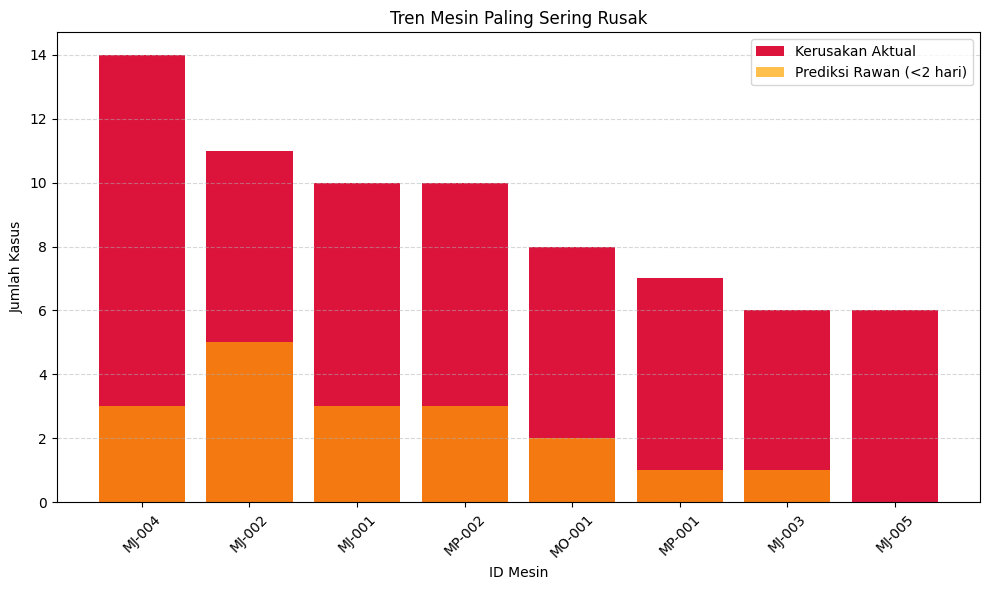

In [28]:
kerusakan_per_mesin = (
    df.groupby('id_mesin')['kerusakan']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)
kerusakan_per_mesin.columns = ['id_mesin', 'total_kerusakan_aktual']
toleransi_kerusakan = 2
rawan_prediksi = (
    df_pred[df_pred['rul_prediksi'] <= toleransi_kerusakan]
    .groupby('id_mesin')
    .size()
    .reset_index(name='jumlah_prediksi_risiko_tinggi')
)
df_tren_kerusakan = kerusakan_per_mesin.merge(rawan_prediksi, on='id_mesin', how='left')
df_tren_kerusakan['jumlah_prediksi_risiko_tinggi'] = df_tren_kerusakan['jumlah_prediksi_risiko_tinggi'].fillna(0).astype(int)
df_tren_kerusakan = df_tren_kerusakan.sort_values(by='total_kerusakan_aktual', ascending=False)
plt.figure(figsize=(10,6))
plt.bar(df_tren_kerusakan['id_mesin'], df_tren_kerusakan['total_kerusakan_aktual'], color='crimson', label='Kerusakan Aktual')
plt.bar(df_tren_kerusakan['id_mesin'], df_tren_kerusakan['jumlah_prediksi_risiko_tinggi'], 
        color='orange', label='Prediksi Rawan (<2 hari)', alpha=0.7)
plt.title('Tren Mesin Paling Sering Rusak')
plt.xlabel('ID Mesin')
plt.ylabel('Jumlah Kasus')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


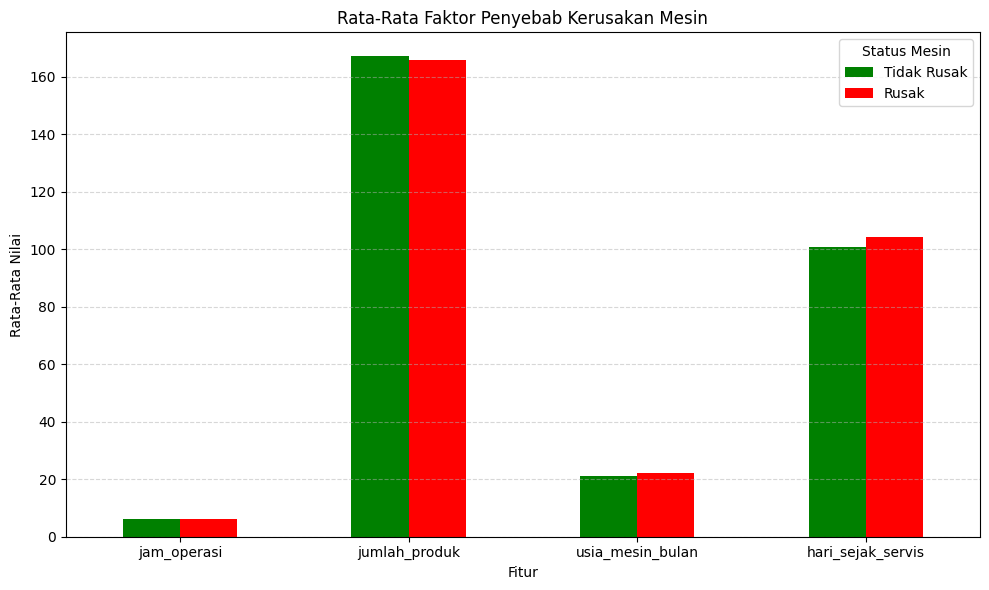

In [29]:
fitur = ['jam_operasi', 'jumlah_produk', 'usia_mesin_bulan', 'hari_sejak_servis']
grup = df.groupby('kerusakan')[fitur].mean().T
grup.columns = ['Tidak Rusak', 'Rusak']

ax = grup.plot(kind='bar', figsize=(10, 6), color=['green', 'red'])
plt.title('Rata-Rata Faktor Penyebab Kerusakan Mesin')
plt.ylabel('Rata-Rata Nilai')
plt.xlabel('Fitur')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Status Mesin')
plt.tight_layout()
plt.show()

In [30]:

# Simpan model ke file
with open('kerusakan_mesin_konveksi.pkl', 'wb') as file:
    pickle.dump(model, file)